In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Number of samples: 569
Number of features: 30
Classes: ['malignant' 'benign']


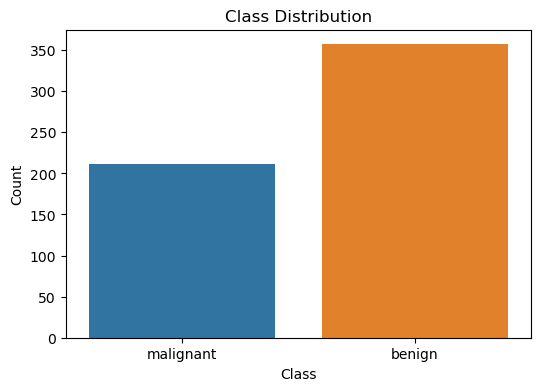

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display some basic information about the dataset
print("Number of samples:", len(X))
print("Number of features:", len(X.columns))
print("Classes:", data.target_names)

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], data.target_names)
plt.show()

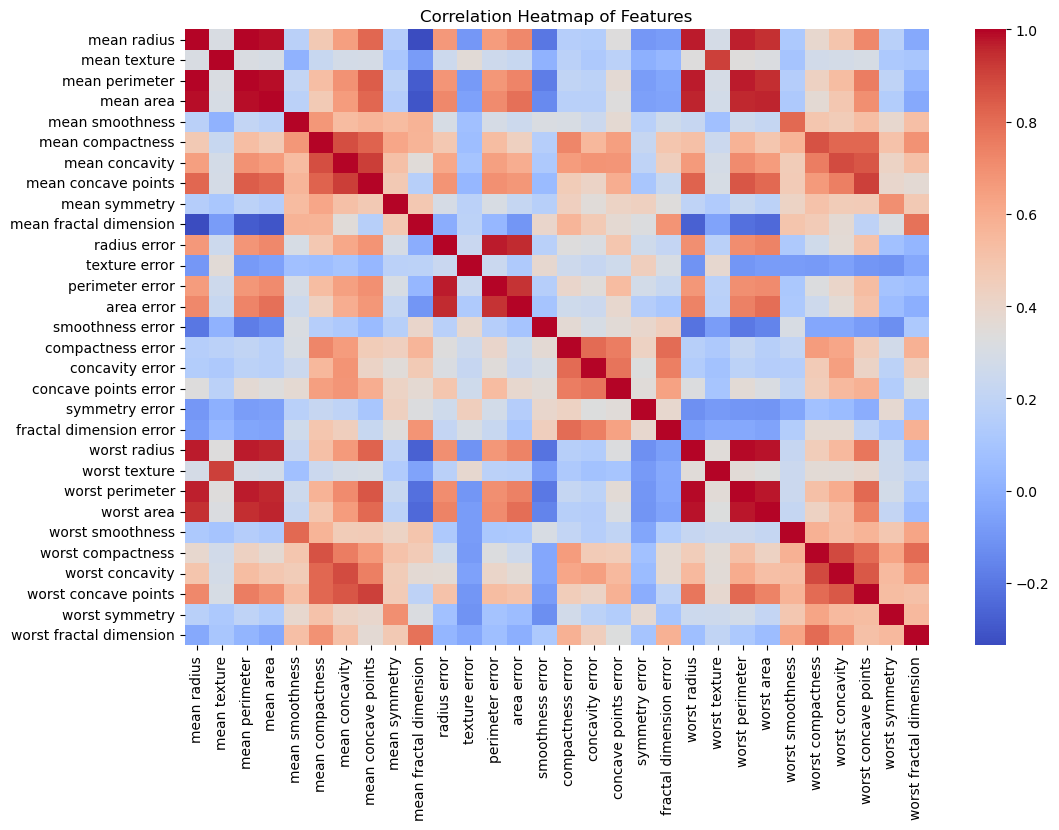

In [3]:
# Visualize correlation heatmap of features
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

In [4]:
# Identify highly correlated features
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)] 
#going below 0.95 has an impact on the accuracy of the model

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  
# 60% train, 20% val, 20% test

# Remove highly correlated columns from the training, validation, and test sets
X_train_no_corr = X_train.drop(columns=to_drop)
X_val_no_corr = X_val.drop(columns=to_drop)
X_test_no_corr = X_test.drop(columns=to_drop)

# Scale the features again after removing correlated columns
scaler = StandardScaler()
X_train_no_corr_scaled = scaler.fit_transform(X_train_no_corr)
X_val_no_corr_scaled = scaler.transform(X_val_no_corr)
X_test_no_corr_scaled = scaler.transform(X_test_no_corr)

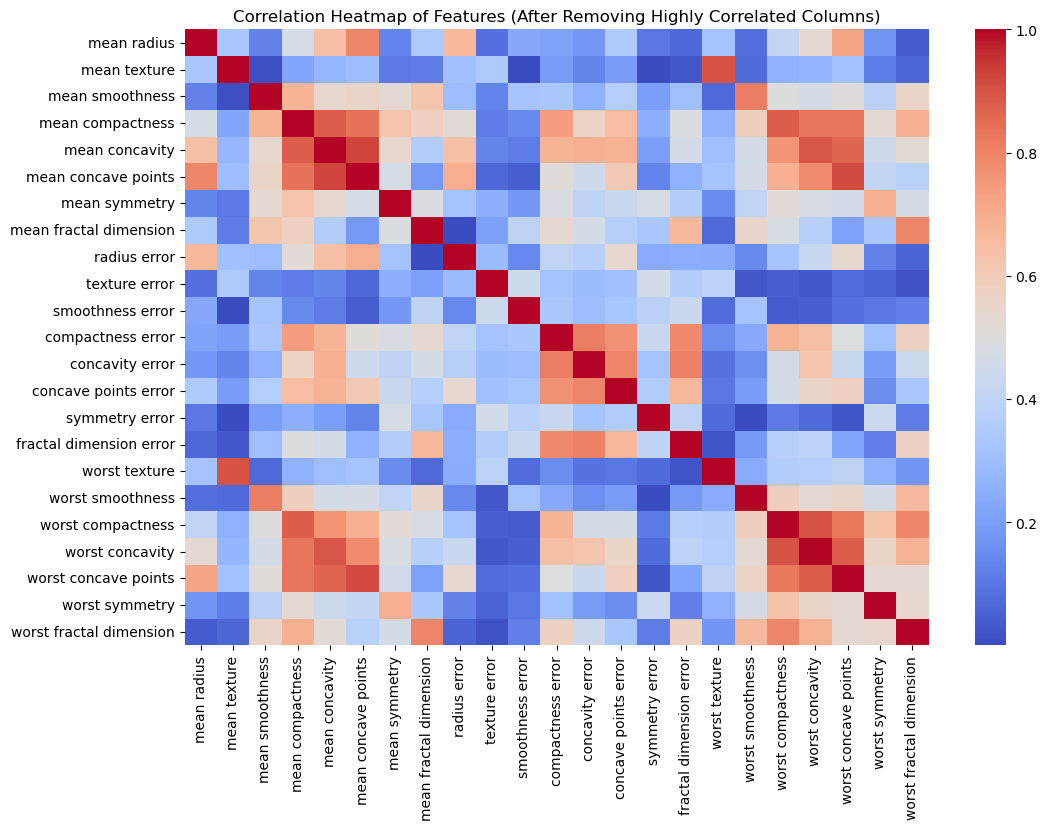

In [5]:
# Regenerate correlation matrix after removing highly correlated columns
corr_matrix_no_corr = X_train_no_corr.corr().abs()

# Plot the correlation heatmap of remaining features
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_no_corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Features (After Removing Highly Correlated Columns)")
plt.show()

As this is a binary classification problem we will evaluate three models i.e. Logistic Regression, Support Vector Machine and Random Forest. We will follow below steps:

1. We train each model using the training set (X_train_no_corr_scaled, y_train) and store the best models in a dictionary best_models.
2. We then perform hyperparameter tuning using the validation set (X_val_no_corr_scaled, y_val) for each model and store the best hyperparameters in a dictionary best_params.
3. Finally, we evaluate the performance of each best model on the test set (X_test_no_corr_scaled, y_test) and print the accuracy, classification report, and confusion matrix.

Model: Logistic Regression
Best hyperparameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Accuracy on test set: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91        43
           1       0.92      0.99      0.95        71

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



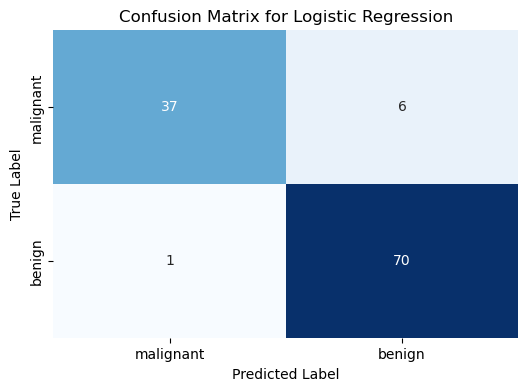

--------------------------------------------------
Model: Support Vector Machine
Best hyperparameters: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
Accuracy on test set: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



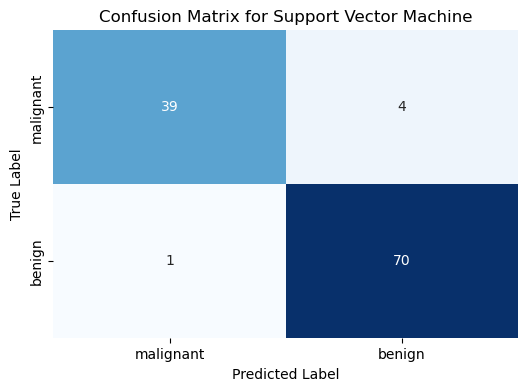

--------------------------------------------------
Model: Random Forest
Best hyperparameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Accuracy on test set: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92        43
           1       0.93      0.97      0.95        71

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



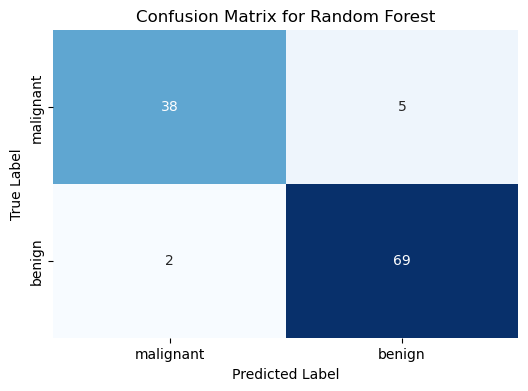

--------------------------------------------------


In [6]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier()
}

param_grids = {
    "Logistic Regression": {
        "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]  # Alternatively, you can use "liblinear" solver for L1 penalty
    },
    "Support Vector Machine": {
        "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "clf__gamma": [0.001, 0.01, 0.1, 1],
        "clf__kernel": ["linear", "rbf"]
    },
    "Random Forest": {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    }
}

# Train the model using the training set
best_models = {}
for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    pipe.fit(X_train_no_corr_scaled, y_train)
    best_models[name] = pipe

# Hyperparameter tuning using the validation set
best_params = {}
for name, model in best_models.items():
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_val_no_corr_scaled, y_val)
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_

# Final evaluation using the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test_no_corr_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {name}")
    print(f"Best hyperparameters: {best_params[name]}")
    print(f"Accuracy on test set: {accuracy:.2f}")
    print("Classification Report:\n", report)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks([0.5, 1.5], data.target_names)
    plt.yticks([0.5, 1.5], data.target_names)
    plt.show()
    
    print("-" * 50)

**As seen in the output, the best model out of Logistic Regression, Support Vector Machine, and Random forest for this particular problem and data is SVM which has an accuracy of 96% on the test data set.**